In [73]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

In [74]:
import pandas as pd
from mllm_emotion_classifier.utils import (
    add_fairness_metrics_to_df,
    plot_fairness_vs_hparam,
    plot_fairness_by_emotion,
    FigureCollector,
)
from EmoBox.EmoBox import EmoDataset

In [75]:
hparam = 'temperature' # or 'top_p'
assert hparam in ['temperature', 'top_p'], "hparam must be either 'temperature' or 'top_p'"

dataset = 'tess'  # 'cremad', 'iemocap', 'emovdb', 'tess' (agegroup)
fold = None # Set to an integer fold number if needed, else None to aggregate all folds
sensitive_attr = 'agegroup' # gender, age, ethnicity, race
model = 'qwen2-audio-instruct'

metadata_dir = Path('EmoBox/data/')
dataset_path = metadata_dir / dataset
n_folds = len([d for d in dataset_path.iterdir() if d.is_dir() and d.name.startswith("fold_")])
out_dir = Path('outputs-2') / "temperature_runs" if hparam == 'temperature' else Path('outputs-2') / "topp_runs"

test = EmoDataset(dataset, './', metadata_dir, fold=1, split="test")
emotions = set(test.label_map.values())

if fold is None:
    dfs = []
    for f in range(1, n_folds + 1):
        results_csv = out_dir / model / dataset / f'fold_{f}.csv'
        df_fold = pd.read_csv(results_csv)
        dfs.append(df_fold)
    df = pd.concat(dfs, ignore_index=True)
else:
    results_csv = out_dir / model / dataset / f'fold_{fold}.csv'
    df = pd.read_csv(results_csv)

print(len(df), "rows")
df.head(5)

since there is no official valid data, use random split for train valid split, with a ratio of [80, 20]
load in 2100 samples, only 2100 exists in data dir EmoBox/data
load in 700 samples, only 700 exists in data dir EmoBox/data
Num. training samples 2100
Num. valid samples 0
Num. test samples 700
Using label_map {'fear': 'Fear', 'disgust': 'Disgust', 'angry': 'Angry', 'sad': 'Sad', 'ps': 'Surprise', 'neutral': 'Neutral', 'happy': 'Happy'}
60 rows


,run,dataset,fold,model,prompt,temperature,valid_rate,global_f1_macro,global_f1_weighted,global_accuracy_unweighted,...,language_statistical_parity,language_Angry_equal_opportunity,language_Disgust_equal_opportunity,language_Fear_equal_opportunity,language_Happy_equal_opportunity,language_Neutral_equal_opportunity,language_Sad_equal_opportunity,language_Surprise_equal_opportunity,language_equal_opportunity,language_overall_accuracy_equality
0,0,tess,1,qwen2-audio-instruct,user_labels,0.0001,1.0,0.6737,0.6737,0.7086,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tess,1,qwen2-audio-instruct,user_labels,0.3000,1.0,0.7494,0.7494,0.7886,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tess,1,qwen2-audio-instruct,user_labels,0.7000,1.0,0.6920,0.6920,0.7186,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tess,1,qwen2-audio-instruct,user_labels,1.0000,1.0,0.6133,0.7009,0.7129,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tess,1,qwen2-audio-instruct,user_labels,1.2000,1.0,0.5736,0.6555,0.6643,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
emotions

{'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'}

In [77]:
run = None
# df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='statistical_parity', run=run)
# df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='equal_opportunity', run=run)
# df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='equal_non_opportunity', run=run)
# df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='predictive_parity', run=run)
# df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='negative_predictive_parity', run=run)
# df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='overall_accuracy_equality', run=run)

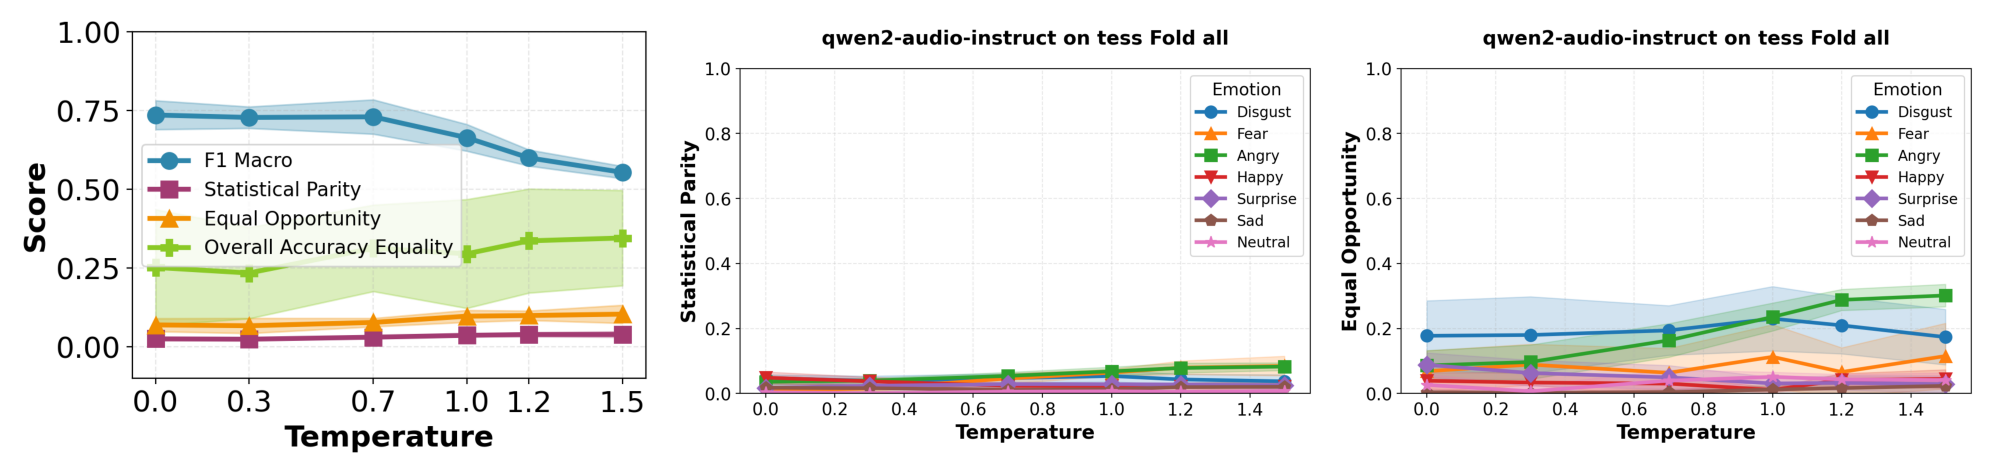

In [78]:
show_std = True
fold = fold if fold is not None else 'all'
os.makedirs(out_dir / 'figures', exist_ok=True)
outpath = out_dir / 'figures' / f'{dataset}_{sensitive_attr}_f1_fairness_fold_{fold}.png'

with FigureCollector() as collector:
    plot_fairness_vs_hparam(df, hparam, [f'{sensitive_attr}_statistical_parity', f'{sensitive_attr}_equal_opportunity', f'{sensitive_attr}_overall_accuracy_equality'], sensitive_attr, model, dataset, fold, show_std=show_std, output_path=outpath)
    plot_fairness_by_emotion(df, emotions, hparam, 'statistical_parity', model, dataset, fold, show_std=show_std, sensitive_attr=sensitive_attr)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_opportunity', model, dataset, fold, show_std=show_std, sensitive_attr=sensitive_attr)
    # plot_fairness_by_emotion(df, emotions, hparam, 'overall_accuracy_equality', model, dataset, fold, show_std=show_std, sensitive_attr=sensitive_attr)
    # plot_fairness_by_emotion(df, emotions, hparam, 'equal_non_opportunity', model, dataset, fold, show_std=show_std, sensitive_attr=sensitive_attr)
    # plot_fairness_by_emotion(df, emotions, hparam, 'predictive_parity', model, dataset, fold, show_std=show_std, sensitive_attr=sensitive_attr)
    # plot_fairness_by_emotion(df, emotions, hparam, 'negative_predictive_parity', model, dataset, fold, show_std=show_std, sensitive_attr=sensitive_attr)
    
collector.display_grid(nrows=1, ncols=3, figsize=(20, 18))
        # , title=f'Fairness Metrics by Emotion - {model} on {dataset} Fold {fold}')